# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [44]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [45]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1691562670.zip, parmi :

data_BEN_1691388940.zip
data_BEN_1691562670.zip
data_BEN_1691467495.zip


In [46]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-08-09.zip, parmi 

File-Export-2020-08-03-to-2023-08-08.zip
File-Export-2020-08-03-to-2023-08-07.zip
File-Export-2020-08-03-to-2023-08-09.zip


In [47]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_b6f9acd2-aa95-45b3-86ca-d1952ba19e1d.zip, parmi :

polar-user-data-export_b6f9acd2-aa95-45b3-86ca-d1952ba19e1d.zip


In [48]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-08-09.zip, data_BEN_1691562670.zip, polar-user-data-export_b6f9acd2-aa95-45b3-86ca-d1952ba19e1d.zip


In [49]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [50]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [51]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-07-26,72.124286,11.437143,3.037143,57.631429,40.908571,0.158575,1680.842286
2023-07-27,72.270000,11.607500,3.035000,57.612500,40.842500,0.160613,1680.310000
2023-07-28,71.691429,11.501429,3.010000,57.164286,40.408571,0.160430,1670.104000
2023-07-29,70.965714,11.650000,2.965714,56.331429,39.531429,0.164164,1651.219429
2023-07-30,71.705000,12.053750,2.980000,56.655000,39.783750,0.168102,1658.467000
2023-07-31,71.582857,11.621429,2.998571,56.945714,40.161429,0.162349,1665.166857
2023-08-01,72.028571,11.637143,3.021429,57.354286,40.570000,0.161563,1674.454857
2023-08-02,71.371429,11.175714,3.015714,57.165714,40.495714,0.156585,1670.227429
2023-08-03,71.900000,11.585714,3.018571,57.282857,40.511429,0.161136,1672.788571


In [52]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-07-26,73.222526,11.330587,3.106429,58.769413,42.151735,0.154768,1706.865878
2023-07-27,72.860893,11.412474,3.079796,58.352423,41.679031,0.156639,1697.285837
2023-07-28,72.700077,11.525944,3.063265,58.094668,41.366378,0.158552,1691.361265
2023-07-29,72.356607,11.562474,3.043061,57.734668,40.985765,0.159818,1683.153265
2023-07-30,72.141811,11.651582,3.026122,57.447628,40.671403,0.161528,1676.588959
2023-07-31,71.896327,11.639643,3.013776,57.225765,40.447321,0.161909,1671.544367
2023-08-01,71.766837,11.644056,3.006837,57.099235,40.315179,0.162257,1668.652061
2023-08-02,71.659286,11.606709,3.003776,57.032704,40.256199,0.161972,1667.135653
2023-08-03,71.606429,11.603597,3.001429,56.985612,40.208903,0.162047,1666.061163


In [53]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [54]:
# df_food.tail(15)

In [55]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [56]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-07-25,1732.8,55.3,178.5,133.7
2023-07-26,1949.8,33.7,221.4,168.1
2023-07-27,1739.0,16.1,207.4,185.8
2023-07-28,1788.0,20.2,227.4,175.2
2023-07-29,2713.2,83.7,281.1,191.6
2023-07-30,1724.5,36.7,177.8,174.5
2023-07-31,1683.3,35.3,177.9,168.2
2023-08-01,1683.5,29.9,182.5,172.4
2023-08-02,1680.8,34.4,178.6,151.3


In [57]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-07-25,1970.800000,38.542857,220.585714,168.271429
2023-07-26,1942.585714,37.528571,215.385714,167.757143
2023-07-27,1900.114286,36.414286,212.957143,171.142857
2023-07-28,1833.414286,31.885714,215.042857,163.085714
2023-07-29,1962.985714,37.657143,229.714286,165.071429
2023-07-30,1919.228571,38.200000,217.900000,170.742857
2023-07-31,1904.371429,40.142857,210.214286,171.014286
2023-08-01,1897.328571,36.514286,210.785714,176.542857
2023-08-02,1858.900000,36.614286,204.671429,174.142857


In [58]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [59]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 1515/1515 [00:13<00:00, 115.07it/s]


In [60]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-07-12,7440.713,445.0
2023-07-13,10470.588,784.0
2023-07-14,11451.726,569.0
2023-07-15,7920.000,484.0
2023-07-16,6600.713,386.0
2023-07-17,7770.674,644.0
2023-07-18,9961.529,1404.0
2023-07-19,4335.387,541.0
2023-07-20,11285.762,889.0
2023-07-21,5700.736,441.0


In [61]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [62]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-07-27,281,1740
2023-07-28,305,3240
2023-07-29,57,2460
2023-07-30,464,5280
2023-07-31,0,0
2023-08-01,406,3060
2023-08-02,422,3960
2023-08-03,230,1740
2023-08-04,486,2820


In [63]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [64]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-07-25,5160.603,315.0
2023-07-26,3180.000,170.0
2023-07-27,1740.000,281.0
2023-07-28,3240.000,305.0
2023-07-29,2460.000,57.0
2023-07-30,5280.000,464.0
2023-07-31,0.000,0.0
2023-08-01,3060.000,406.0
2023-08-02,3960.000,422.0
2023-08-03,1740.000,230.0


In [65]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-07-25,6924.416143,491.571429
2023-07-26,6759.360857,438.571429
2023-07-27,5395.680571,351.714286
2023-07-28,5044.146857,332.285714
2023-07-29,4020.187857,250.857143
2023-07-30,3437.229000,253.142857
2023-07-31,3008.657571,227.428571
2023-08-01,2708.571429,240.428571
2023-08-02,2820.000000,276.428571
2023-08-03,2820.000000,269.142857


In [66]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [67]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [68]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [69]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [70]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-07-25,72.935000,11.606250,3.070000,58.240000,41.495000,0.159131,1694.701000,1732.8,55.3,178.5,133.7,5160.603,315.0,213.776863,1908.477863,-175.677863
2023-07-26,72.124286,11.437143,3.037143,57.631429,40.908571,0.158575,1680.842286,1949.8,33.7,221.4,168.1,3180.000,170.0,108.135666,1788.977952,160.822048
2023-07-27,72.270000,11.607500,3.035000,57.612500,40.842500,0.160613,1680.310000,1739.0,16.1,207.4,185.8,1740.000,281.0,247.160424,1927.470424,-188.470424
2023-07-28,71.691429,11.501429,3.010000,57.164286,40.408571,0.160430,1670.104000,1788.0,20.2,227.4,175.2,3240.000,305.0,242.371100,1912.475100,-124.475100
2023-07-29,70.965714,11.650000,2.965714,56.331429,39.531429,0.164164,1651.219429,2713.2,83.7,281.1,191.6,2460.000,57.0,9.986113,1661.205542,1051.994458
2023-07-30,71.705000,12.053750,2.980000,56.655000,39.783750,0.168102,1658.467000,1724.5,36.7,177.8,174.5,5280.000,464.0,362.649239,2021.116239,-296.616239
2023-07-31,71.582857,11.621429,2.998571,56.945714,40.161429,0.162349,1665.166857,1683.3,35.3,177.9,168.2,0.000,0.0,0.000000,1665.166857,18.133143
2023-08-01,72.028571,11.637143,3.021429,57.354286,40.570000,0.161563,1674.454857,1683.5,29.9,182.5,172.4,3060.000,406.0,346.696390,2021.151248,-337.651248
2023-08-02,71.371429,11.175714,3.015714,57.165714,40.495714,0.156585,1670.227429,1680.8,34.4,178.6,151.3,3960.000,422.0,345.447910,2015.675338,-334.875338
2023-08-03,71.900000,11.585714,3.018571,57.282857,40.511429,0.161136,1672.788571,1757.5,65.1,192.2,76.3,1740.000,230.0,196.311897,1869.100468,-111.600468


In [71]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-07-25,73.508852,11.322015,3.122959,59.048189,42.446837,0.154040,1713.235673,1970.800000,38.542857,220.585714,168.271429,6924.416143,491.571429,353.988146,2067.223819,-96.423819
2023-07-26,73.222526,11.330587,3.106429,58.769413,42.151735,0.154768,1706.865878,1942.585714,37.528571,215.385714,167.757143,6759.360857,438.571429,304.518788,2011.384665,-68.798951
2023-07-27,72.860893,11.412474,3.079796,58.352423,41.679031,0.156639,1697.285837,1900.114286,36.414286,212.957143,171.142857,5395.680571,351.714286,245.433910,1942.719746,-42.605461
2023-07-28,72.700077,11.525944,3.063265,58.094668,41.366378,0.158552,1691.361265,1833.414286,31.885714,215.042857,163.085714,5044.146857,332.285714,233.191360,1924.552625,-91.138339
2023-07-29,72.356607,11.562474,3.043061,57.734668,40.985765,0.159818,1683.153265,1962.985714,37.657143,229.714286,165.071429,4020.187857,250.857143,172.246646,1855.399911,107.585803
2023-07-30,72.141811,11.651582,3.026122,57.447628,40.671403,0.161528,1676.588959,1919.228571,38.200000,217.900000,170.742857,3437.229000,253.142857,186.433571,1863.022530,56.206042
2023-07-31,71.896327,11.639643,3.013776,57.225765,40.447321,0.161909,1671.544367,1904.371429,40.142857,210.214286,171.014286,3008.657571,227.428571,169.154201,1840.698568,63.672861
2023-08-01,71.766837,11.644056,3.006837,57.099235,40.315179,0.162257,1668.652061,1897.328571,36.514286,210.785714,176.542857,2708.571429,240.428571,188.142705,1856.794766,40.533806
2023-08-02,71.659286,11.606709,3.003776,57.032704,40.256199,0.161972,1667.135653,1858.900000,36.614286,204.671429,174.142857,2820.000000,276.428571,222.044454,1889.180107,-30.280107
2023-08-03,71.606429,11.603597,3.001429,56.985612,40.208903,0.162047,1666.061163,1861.542857,43.614286,202.500000,158.500000,2820.000000,269.142857,214.780378,1880.841542,-19.298685


# Graphes

In [72]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [73]:
def plot_general(longueur=15,
                 year=2023,
                 month=3,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

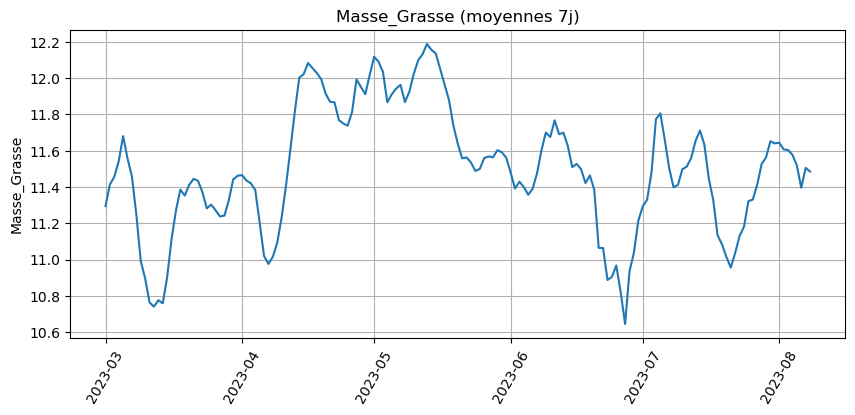

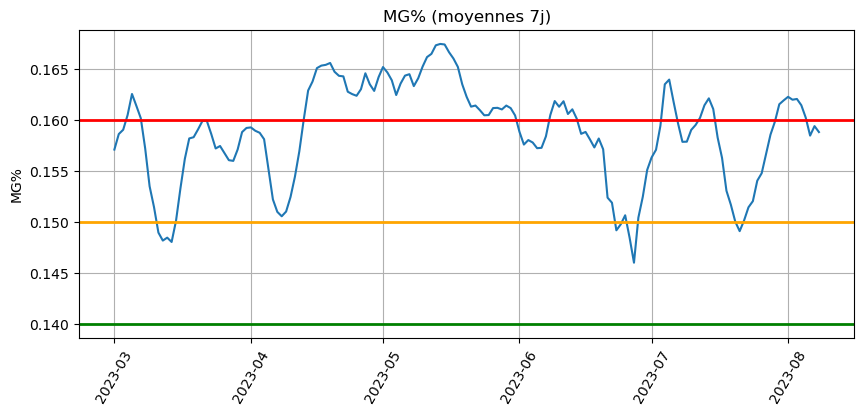

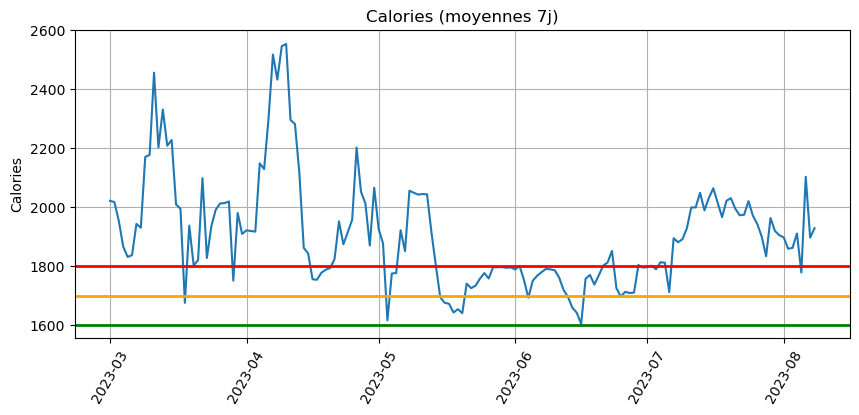

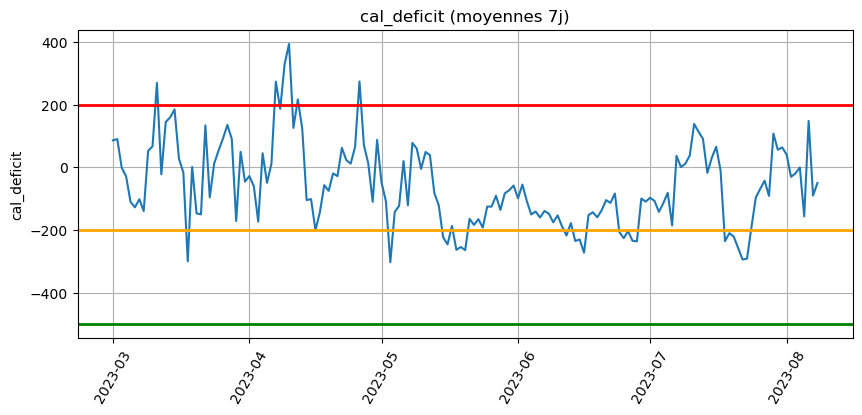

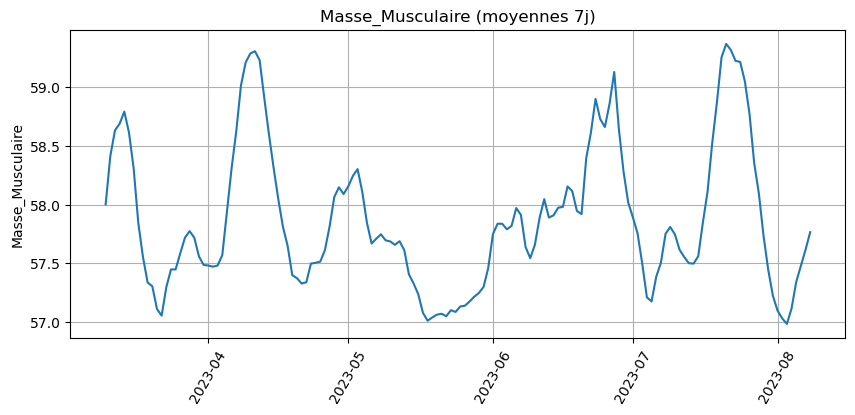

In [74]:
plot_general(longueur=7)

In [75]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=3, day=1)>

In [76]:
def plot_general2(longueur=15,
                 year=2023,
                 month=3,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [77]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general2(longueur=15, year=2023, month=3, day=1)>

In [78]:
def plot_general3(longueur=15,
                 year=2023,
                 month=3,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.14, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [79]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general3(longueur=15, year=2023, month=3, day=1)>

In [80]:
def scatter_plot(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['cal_deficit'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    # print(delta)
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie deficit over {LENGTH} days')
    ax.set_ylabel(f'average weekly total masse variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=-500, stop=500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')
    

In [81]:
ipywidgets.interact(scatter_plot, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot(mass_interval=2.0, length=15)>

In [82]:
def scatter_plot2(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_Masse_Totale'] = (df_corr['Masse_Totale'] - df_corr['Masse_Totale'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_Masse_Totale'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly total masse variation (g) over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [83]:
ipywidgets.interact(scatter_plot2, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot2(mass_interval=2.0, length=15)>

In [84]:
def scatter_plot3(mass_interval=2.0, length=15):
    """Utility plot to scatter mass_delta over LENGTH vs average cal_deficit over LENGTH"""
    
    MASS_INTERVAL = mass_interval
    LENGTH = int(length)

    current_mass = df_all['Masse_Totale'].iloc[-1]

    df_corr = df_all[(df_all['Masse_Totale'] - current_mass) <= MASS_INTERVAL]
    df_corr = df_corr.drop(columns=['Masse_Osseuse', 'Masse_Musculaire', 'Masse_Hydrique']).copy()
    
    df_corr = df_corr.rolling(window=LENGTH).mean().dropna().copy()

    df_corr['Delta_MG'] = (df_corr['Masse_Grasse'] - df_corr['Masse_Grasse'].shift(periods=LENGTH))/LENGTH*7

    df_corr.dropna(inplace=True)
    
    fig, ax = plt.subplots() #figsize=(8,8))
    cal = df_corr['Calories'].to_numpy()
    delta = df_corr['Delta_MG'].to_numpy()
    
    ax.scatter(x=cal, y=delta)
    ax.set_xlabel(f'average calorie intake over {LENGTH} days')
    ax.set_ylabel(f'average weekly MG variation over {LENGTH} days')
    ax.grid()
    
    lr = LinearRegression()
    lr.fit(cal.reshape(-1,1), delta)
    x_cal = np.linspace(start=1500, stop=2500, num=100)
    y_pred = lr.predict(x_cal.reshape(-1,1))
    
    ax.scatter(x_cal, y_pred, color='red', marker='.')

In [85]:
ipywidgets.interact(scatter_plot3, mass_interval=(1.0, 10.0, 0.5), length=(1, 30, 7))

interactive(children=(FloatSlider(value=2.0, description='mass_interval', max=10.0, min=1.0, step=0.5), IntSli…

<function __main__.scatter_plot3(mass_interval=2.0, length=15)>